In [2]:
"""Capstone 3 Project:

'Identifying similar Netflix movies based on characteristics'"""

"Capstone 3 Project:\n\n'Identifying similar Netflix movies based on characteristics'"

In [3]:
"""The dataset we will work with for this project can be found 
at the link below:

https://www.kaggle.com/datasets/shivamb/netflix-shows
"""

'The dataset we will work with for this project can be found \nat the link below:\n\nhttps://www.kaggle.com/datasets/shivamb/netflix-shows\n'

In [4]:
"""About this Dataset: Netflix is one of the most popular media and 
video streaming platforms. They have over 8000 movies or tv shows 
available on their platform, as of mid-2021, they have over 200M 
Subscribers globally. This tabular dataset consists of listings of all 
the movies and tv shows available on Netflix, along with details such 
as - cast, directors, ratings, release year, duration, etc."""

'About this Dataset: Netflix is one of the most popular media and \nvideo streaming platforms. They have over 8000 movies or tv shows \navailable on their platform, as of mid-2021, they have over 200M \nSubscribers globally. This tabular dataset consists of listings of all \nthe movies and tv shows available on Netflix, along with details such \nas - cast, directors, ratings, release year, duration, etc.'

In [6]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
!pip install umap-learn
!pip install --upgrade umap
!pip install --upgrade numba
import umap
import warnings
import time
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN

#path = "/content/drive/MyDrive/python_for_data_scientists/Capstone 3: Unsupervised/netflix_titles 2.csv"

path = "https://raw.githubusercontent.com/adamastor1/Identifying-Netflix-Movies-Based-on-Characteristics/main/movies_data.csv"

df = pd.read_csv(path)

def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

     |████████████████████████████████| 90 kB 4.1 MB/s eta 0:00:011
     |████████████████████████████████| 1.1 MB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 640 kB 46.0 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86785 sha256=f2d1d8cd2dd815f7f105fa9b9c7f7e7b803c21f13d302079e89bacddfb9f5968
  Stored in directory: /Users/adamastor/Library/Caches/pip/wheels/b0/b0/fa/673b574ab0d1ca1b9d6000d87258c23bb6c0c5e2aae5ba73f5
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=decc3f5d5b33134d1baa15f58ec96d90c864997cd13bb8c433e1f3b045e494b6
  Stored in directory: /Users/adamastor/Library/Caches/pip/wheels/f8/32/54/fa1fd0454e0441eaa32550ea2a86da3f64eb7c8e5a82436770
Successfully built umap-learn pynndescent
  Using cached umap-0.1.1.tar.gz (3.2 kB)
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3566 sha256=059f6af131710e1e4ae9b7ebe18eedc20386964fc1f0a99d8352a39eada

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


In [3]:
df.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [4]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [5]:
df.star

0         Jack Nicholson
1         Brooke Shields
2            Mark Hamill
3            Robert Hays
4            Chevy Chase
              ...       
7663        Shannon Bond
7664    Michael Saquella
7665        Onyama Laura
7666       Christina Roz
7667    Siyabonga Mabaso
Name: star, Length: 7668, dtype: object

In [6]:
df.star[0:20]

0        Jack Nicholson
1        Brooke Shields
2           Mark Hamill
3           Robert Hays
4           Chevy Chase
5          Betsy Palmer
6          John Belushi
7        Robert De Niro
8          Gene Hackman
9       David Carradine
10       Clint Eastwood
11                N!xau
12       Robin Williams
13    Donald Sutherland
14        Michael Caine
15    Christopher Reeve
16          Eddie Barth
17           Jane Fonda
18     Adrienne Barbeau
19          Gene Wilder
Name: star, dtype: object

In [7]:
'Robin Williams' in df.star

False

In [8]:
"""The research question we want to answer is:

On average, do movies made by Warner Bros. have a higher score than 
movies made by Paramount Pictures?

We are curious as to what impact these production ccompanies have on Rotten Tomatoes 
scores in our sample. Does Warner Bros. create a better movie experience than Paramount?"""

'The research question we want to answer is:\n\nOn average, do movies made by Warner Bros. have a higher score than \nmovies made by Paramount Pictures?\n\nWe are curious as to what impact these production ccompanies have on Rotten Tomatoes \nscores in our sample. Does Warner Bros. create a better movie experience than Paramount?'

In [9]:
"""To observe the average of our two sample populations, we will use the following code to
make variables "wb" and "pp"""

wb = df[df["company"] == 'Warner Bros.']

pp = df[df["company"] == 'Paramount Pictures']

In [10]:
wb.shape

(334, 15)

In [11]:
pp.shape

(320, 15)

In [12]:
wb["score"].mean()

6.434730538922159

In [13]:
pp["score"].mean()

6.335937500000002

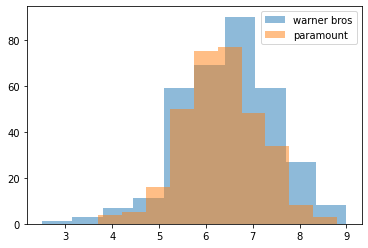

DescribeResult(nobs=334, minmax=(2.5, 9.0), mean=6.434730538922155, variance=1.0150664436891983, skewness=-0.3553264411241064, kurtosis=0.5140150248463589)
DescribeResult(nobs=320, minmax=(3.7, 8.8), mean=6.3359375, variance=0.6819959835423198, skewness=-0.07765009257968343, kurtosis=0.4574795244525385)


In [14]:
# Plot our variables, we need kurtosis and skewness to be between -3 and 3 for a
#t-test to work properly


plt.hist(wb['score'], alpha = .5, label = "warner bros")
plt.hist(pp['score'], alpha = .5, label = "paramount")
plt.legend(loc="upper right")
plt.show()

print(stats.describe(wb['score']))
print(stats.describe(pp['score']))

In [15]:
"""It looks like we have a normal distribution. The skewness and kurtosis for both variables
are between -3 and 3. This means we meet all of the assumptions for a t-test."""

'It looks like we have a normal distribution. The skewness and kurtosis for both variables\nare between -3 and 3. This means we meet all of the assumptions for a t-test.'

In [16]:
stats.ttest_ind(wb['score'], pp['score'])

Ttest_indResult(statistic=1.3681653747077522, pvalue=0.17173161731719616)

In [17]:
"""The t-statistic is less than 1.96 which satisfies rejecting the null
hypothesis, however the p-value is nowhere near being at or below 0.05 meaning the test isn't significant. 
There is a high probability that you would find an effect at least as extreme as this sample's, 
assuming that the null is true."""

"The t-statistic is less than 1.96 which satisfies rejecting the null\nhypothesis, however the p-value is nowhere near being at or below 0.05 meaning the test isn't significant. \nThere is a high probability that you would find an effect at least as extreme as this sample's, \nassuming that the null is true."

In [18]:
"""Lets calculate the 95% confidence interval"""

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

get_95_ci(wb['score'], pp['score'])

'The difference in means at the 95% confidence interval (two-tail) is between -0.23972724114966756 and 0.04214116330535231.'

[[Text(0, 0, 'warner bros.'), Text(0, 0, 'paramount')]]

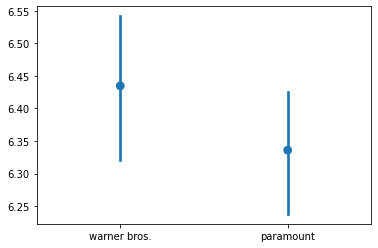

In [19]:
# Create a point plot to compare the means

g = sns.pointplot(data=[wb['score'], pp['score']], join=False)

g.set(xticklabels = ['warner bros.', 'paramount'])

In [20]:
#Let's take a preliminary look at our data

df.info()

df.columns

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [21]:
"""It looks like there is a good mix of numerical and catergorical variables 
in this dataset. There are 15 variables and 7668 entries in total.

Now that we've seen the data, let's explore it with some EDA"""

df.nunique()

name        7512
rating        12
genre         19
year          41
released    3414
score         72
votes        936
director    2949
writer      4535
star        2814
country       59
budget       413
gross       7472
company     2385
runtime      138
dtype: int64

In [22]:
"""df.unique() gives us all of the unique values for each column.

It looks like there are no variables that have binary
data.

name, released, director, writer, star, gross and 
company all have primarily unique values for each entry."""

'df.unique() gives us all of the unique values for each column.\n\nIt looks like there are no variables that have binary\ndata.\n\nname, released, director, writer, star, gross and \ncompany all have primarily unique values for each entry.'

In [23]:
#Let's do an initial search for missing values in our dataset
df.isnull()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False
7664,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False
7665,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True
7666,False,True,False,False,False,True,True,False,False,False,False,False,True,True,False


In [24]:
"""As we can see above, there are plenty of missing values. However, the above 
is only a snippet of the bigger picture

To get a better idea of how many missing values there are 
in our dataset let's get some percentages of missing values for 
each variable"""

"As we can see above, there are plenty of missing values. However, the above \nis only a snippet of the bigger picture\n\nTo get a better idea of how many missing values there are \nin our dataset let's get some percentages of missing values for \neach variable"

In [25]:
#Percentage of missing values per column

df.isnull().sum()*100/df.isnull().count()

name         0.000000
rating       1.004173
genre        0.000000
year         0.000000
released     0.026082
score        0.039124
votes        0.039124
director     0.000000
writer       0.039124
star         0.013041
country      0.039124
budget      28.312467
gross        2.464789
company      0.221701
runtime      0.052165
dtype: float64

In [26]:
"""Let's also get a count of all of the zero values."""

#Count of 0 values in various column
print((df.name.values == 0).sum())
print((df.rating.values == 0).sum())
print((df.genre.values == 0).sum())
print((df.year.values == 0).sum())
print((df.released.values == 0).sum())
print((df.score.values == 0).sum())
print((df.votes.values == 0).sum())
print((df.director.values == 0).sum())
print((df.writer.values == 0).sum())
print((df.star.values == 0).sum())
print((df.country.values == 0).sum())
print((df.budget.values == 0).sum())
print((df.gross.values == 0).sum())
print((df.company.values == 0).sum())
print((df.runtime.values == 0).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [27]:
"""Check the whole dataset"""
print((df.values == 0).sum())

0


In [28]:
"""There are no zero values in the dataset.

There appears to be a small amount of missing values in the rating,
released, score, votes, writer, star, country, gross, company, and runtime columns. =<1% each.

Since we will not lose a significant amount of information from these records
by eliminating them, we will decide to do so. 

There does seem to be a lot of missing values from the budget column, enough that 
would make a difference if we were to drop them. Let's try to impute the values to fill these in.

After doing so we can continue to analyze our data as a whole without any gaps that might deter
our calculations."""

"There are no zero values in the dataset.\n\nThere appears to be a small amount of missing values in the rating,\nreleased, score, votes, writer, star, country, gross, company, and runtime columns. =<1% each.\n\nSince we will not lose a significant amount of information from these records\nby eliminating them, we will decide to do so. \n\nThere does seem to be a lot of missing values from the budget column, enough that \nwould make a difference if we were to drop them. Let's try to impute the values to fill these in.\n\nAfter doing so we can continue to analyze our data as a whole without any gaps that might deter\nour calculations."

In [29]:
"""Start with imputinging the smaller amount of missing values.

Sicne the budget variable is continuous, but does not have a meaningful ordering of the 
observations or a trend in the ordered data, we will impute the mean for the missing values"""

df["budget"].fillna(df["budget"].mean(), inplace=True)

In [30]:
"""Let's check to make sure that worked"""

df.isnull().sum()*100/df.isnull().count()

name        0.000000
rating      1.004173
genre       0.000000
year        0.000000
released    0.026082
score       0.039124
votes       0.039124
director    0.000000
writer      0.039124
star        0.013041
country     0.039124
budget      0.000000
gross       2.464789
company     0.221701
runtime     0.052165
dtype: float64

In [31]:
"""Perfect. Now we will drop the remaining missing values."""

df.dropna(inplace = True)

In [32]:
df.isnull().sum()*100/df.isnull().count()

name        0.0
rating      0.0
genre       0.0
year        0.0
released    0.0
score       0.0
votes       0.0
director    0.0
writer      0.0
star        0.0
country     0.0
budget      0.0
gross       0.0
company     0.0
runtime     0.0
dtype: float64

In [33]:
"""Great.

Now let's test for outliers. Outliers may hinder the reliability of our predictions just as
null values could. We want to handle them in order to increase our accuracy of anaysis.

We will start with statistical tests"""

from scipy.stats import zscore

z_scores = zscore(df["score"])
for threshold in range(1,5):
   print("The score threshold is: {}".format(threshold))
   print("The indices of the outliers:")
   print(np.where(z_scores > threshold))
   print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   0,    2,    3, ..., 7393, 7399, 7403]),)
Number of outliers is: 1141
The score threshold is: 2
The indices of the outliers:
(array([   0,    2,   80,  432,  585, 1142, 1505, 1694, 1696, 2082, 2273,
       2274, 2275, 2276, 2278, 2473, 2476, 2877, 2887, 3062, 3063, 3255,
       3256, 3260, 3450, 3453, 3643, 3647, 3841, 3843, 3848, 4040, 4047,
       4189, 4388, 4634, 4637, 4654, 4924, 5032, 5049, 5254, 5431, 5638,
       5828, 5831, 6227, 6233, 6650, 6696, 6836, 7021, 7029, 7079, 7221,
       7226, 7228]),)
Number of outliers is: 57
The score threshold is: 3
The indices of the outliers:
(array([2273]),)
Number of outliers is: 1
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0


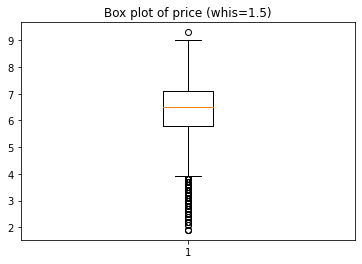

In [34]:
"""From the test above it seems that we have some outliers depending on what
we set our threshold to.

Now let's visually inspect our data for outliers to confirm the statistical test."""

plt.boxplot(df["score"])
plt.title("Box plot of price (whis=1.5)")
plt.show()

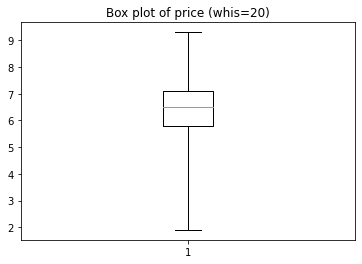

In [35]:
plt.boxplot(df["score"], whis=20)
plt.title("Box plot of price (whis=20)")
plt.show()

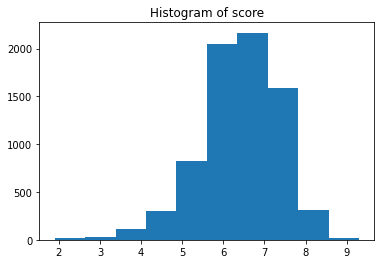

In [36]:
"""The boxplot shows that, depending on what we set 'whis' to, there may or may not be outliers.

Let's confirm with a histogram."""

plt.hist(df["score"])
plt.title("Histogram of score")
plt.show()

In [37]:
"""It looks like there may be a few outliers, but it seems that they won't interfere with our
analysis based on their position and relation to the majority of the data. They are not
too far off to throw off any calculations, so we will say there are no outliers."""

"It looks like there may be a few outliers, but it seems that they won't interfere with our\nanalysis based on their position and relation to the majority of the data. They are not\ntoo far off to throw off any calculations, so we will say there are no outliers."

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7412 entries, 0 to 7659
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7412 non-null   object 
 1   rating    7412 non-null   object 
 2   genre     7412 non-null   object 
 3   year      7412 non-null   int64  
 4   released  7412 non-null   object 
 5   score     7412 non-null   float64
 6   votes     7412 non-null   float64
 7   director  7412 non-null   object 
 8   writer    7412 non-null   object 
 9   star      7412 non-null   object 
 10  country   7412 non-null   object 
 11  budget    7412 non-null   float64
 12  gross     7412 non-null   float64
 13  company   7412 non-null   object 
 14  runtime   7412 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 926.5+ KB


In [39]:
"""Now for some EDA. 

We can leave out 'released' since it is a near duplicate of the 'year' variable.
I will leave them out of my EDA and only use them to engineer new features or 
learn something about other features.

For organization sake, let's make a list of our continuous
and categorical variables that we plan to explore with EDA"""

continuous = ["year", "score", "votes", "budget", "gross", "runtime"]

categorical = ["name", "rating", "genre", "director", "writer", "star", "country", "company"]

In [40]:
"""Now let's explore the data."""

df.describe(include= 'all')

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
count,7412,7412,7412,7412.000000,7412,7412.000000,7.412000e+03,7412,7412,7412,7412,7.412000e+03,7.412000e+03,7412,7412.000000
unique,7267,12,18,NaN,3292,NaN,NaN,2816,4354,2652,57,NaN,NaN,2242,NaN
top,Nobody's Fool,R,Comedy,NaN,"October 4, 1991 (United States)",NaN,NaN,Woody Allen,Woody Allen,Nicolas Cage,United States,NaN,NaN,Universal Pictures,NaN
freq,3,3608,2182,NaN,9,NaN,NaN,38,37,43,5358,NaN,NaN,376,NaN
mean,NaN,NaN,NaN,2000.640718,NaN,6.396910,9.076357e+04,NaN,NaN,NaN,NaN,3.589654e+07,7.899355e+07,NaN,107.446438
std,NaN,NaN,NaN,11.028736,NaN,0.963162,1.653466e+05,NaN,NaN,NaN,NaN,3.555351e+07,1.662164e+08,NaN,18.517471
min,NaN,NaN,NaN,1980.000000,NaN,1.900000,1.050000e+02,NaN,NaN,NaN,NaN,6.000000e+03,3.090000e+02,NaN,63.000000
25%,NaN,NaN,NaN,1991.000000,NaN,5.800000,1.000000e+04,NaN,NaN,NaN,NaN,1.400000e+07,4.633888e+06,NaN,95.000000
50%,NaN,NaN,NaN,2001.000000,NaN,6.500000,3.400000e+04,NaN,NaN,NaN,NaN,3.500000e+07,2.040352e+07,NaN,104.000000
75%,NaN,NaN,NaN,2010.000000,NaN,7.100000,9.600000e+04,NaN,NaN,NaN,NaN,3.558988e+07,7.644231e+07,NaN,116.000000


In [41]:
"""It looks like our target variable 'score' has a range of 1.9 to 9.3.

The highest count for ratings is 'R' and genre is 'Comedy'.

The top star is Nicholas Cage and the top company is Universal Pictures."""

"It looks like our target variable 'score' has a range of 1.9 to 9.3.\n\nThe highest count for ratings is 'R' and genre is 'Comedy'.\n\nThe top star is Nicholas Cage and the top company is Universal Pictures."

In [42]:
"""Now let's plot some histograms to visualize the data with univariate visualization for
the continuous variables."""

"Now let's plot some histograms to visualize the data with univariate visualization for\nthe continuous variables."

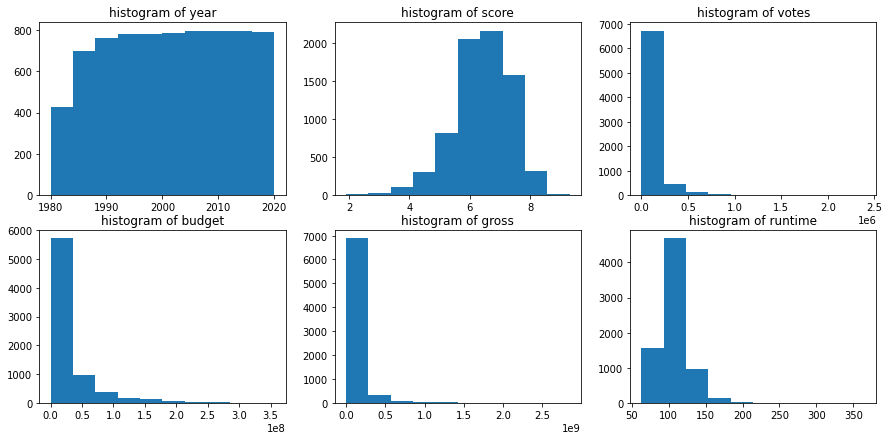

In [43]:
plt.figure(figsize=(15, 7))

# Histograms of the original continuous variables 
#["year","score","votes","budget","gross","runtime"]

plt.subplot(2, 3, 1)
plt.hist(df["year"])
plt.title("histogram of year")

plt.subplot(2, 3, 2)
plt.hist(df["score"])
plt.title("histogram of score")

plt.subplot(2, 3, 3)
plt.hist(df["votes"])
plt.title("histogram of votes")

plt.subplot(2, 3, 4)
plt.hist(df["budget"])
plt.title("histogram of budget")

plt.subplot(2, 3, 5)
plt.hist(df["gross"])
plt.title("histogram of gross")

plt.subplot(2, 3, 6)
plt.hist(df["runtime"])
plt.title("histogram of runtime")


plt.show()

In [44]:
df.nunique()

name        7267
rating        12
genre         18
year          41
released    3292
score         72
votes        853
director    2816
writer      4354
star        2652
country       57
budget       399
gross       7405
company     2242
runtime      136
dtype: int64

In [45]:
"""Now to visualize the categorical variables 
["name", "rating", "genre", "director", "writer", "star", "country", "company"]

Categorical variables for bar chart:
rating, genre, country

Categorical variables for word cloud:
name, director, writer, star, company"""

'Now to visualize the categorical variables \n["name", "rating", "genre", "director", "writer", "star", "country", "company"]\n\nCategorical variables for bar chart:\nrating, genre, country\n\nCategorical variables for word cloud:\nname, director, writer, star, company'

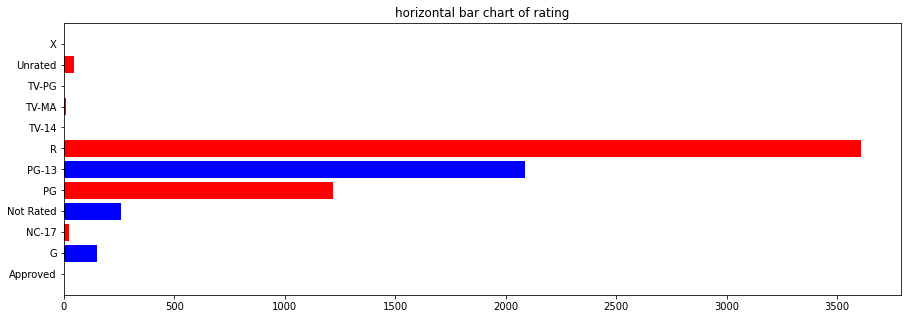

In [46]:
plt.figure(figsize=(15,5))
plt.barh(df.groupby("rating")["rating"].count().index,
       df.groupby("rating")["rating"].count(),
       color=["red","blue"])
plt.title("horizontal bar chart of rating")

plt.show()

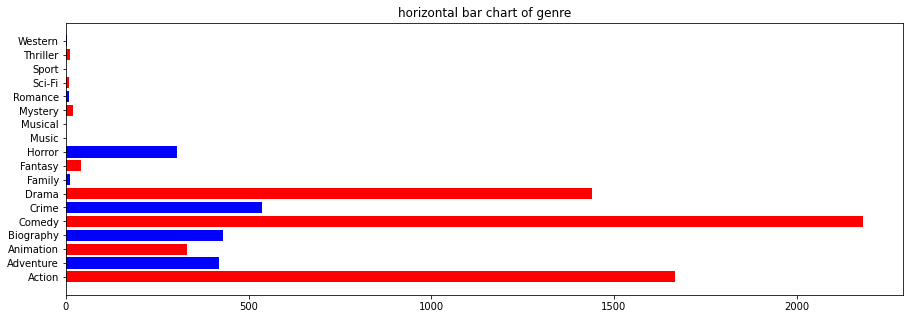

In [47]:
plt.figure(figsize=(15,5))
plt.barh(df.groupby("genre")["genre"].count().index,
       df.groupby("genre")["genre"].count(),
       color=["red","blue"])
plt.title("horizontal bar chart of genre")

plt.show()

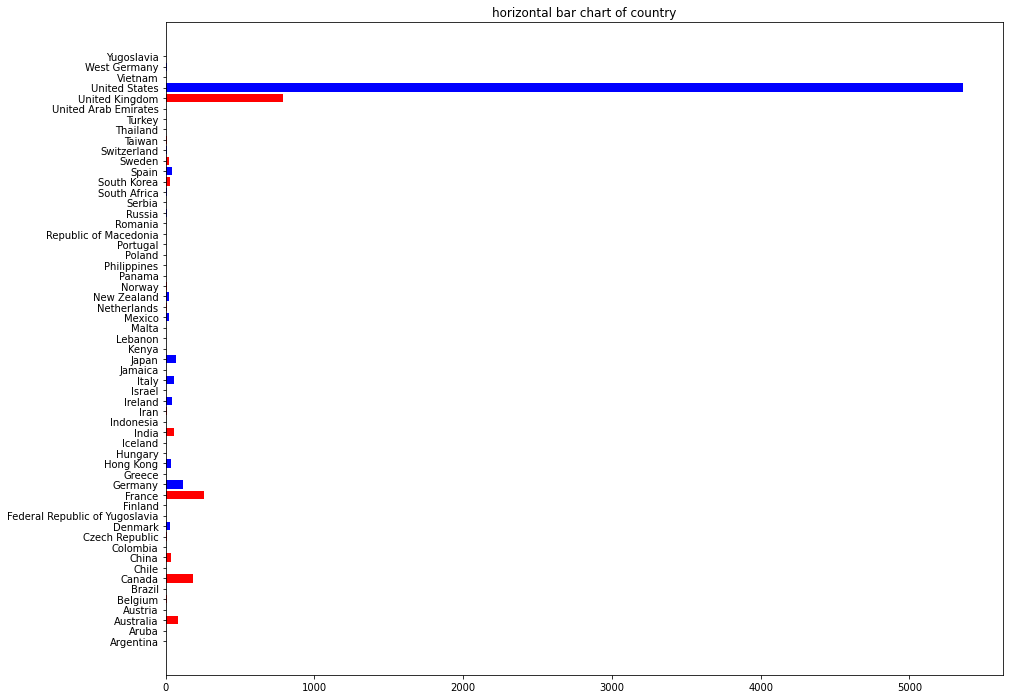

In [48]:
plt.figure(figsize=(15,12))
plt.barh(df.groupby("country")["country"].count().index,
       df.groupby("country")["country"].count(),
       color=["red","blue"])
plt.title("horizontal bar chart of country")

plt.show()

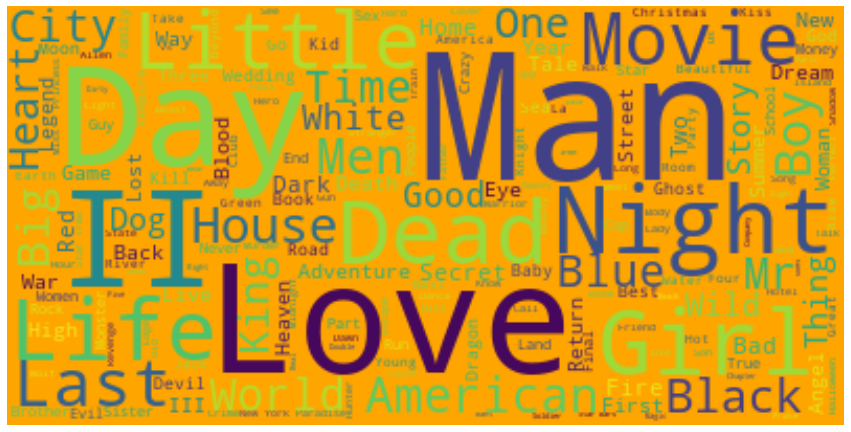

In [49]:
!pip install wordcloud

from wordcloud import WordCloud
#name, director, writer, star, company

wordcloud = WordCloud(background_color="orange").generate(" ".join(df["name"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

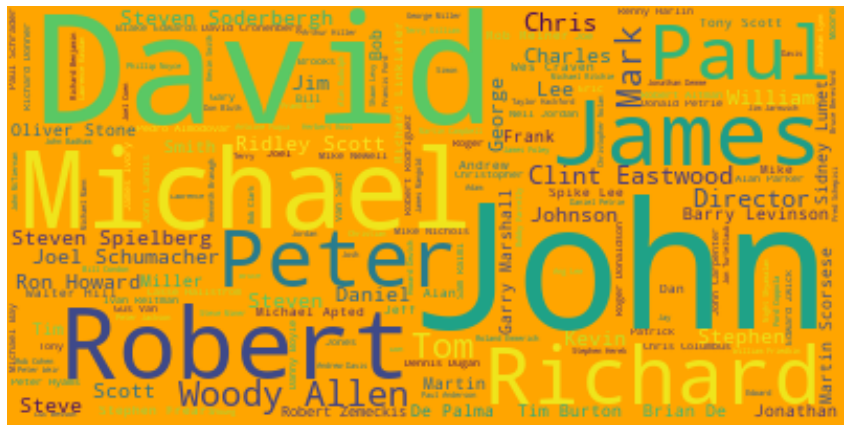

In [50]:
wordcloud = WordCloud(background_color="orange").generate(" ".join(df["director"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

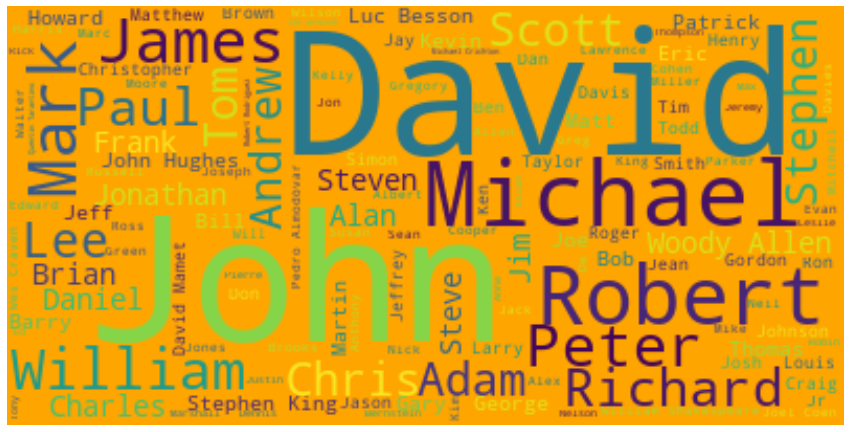

In [51]:
wordcloud = WordCloud(background_color="orange").generate(" ".join(df["writer"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

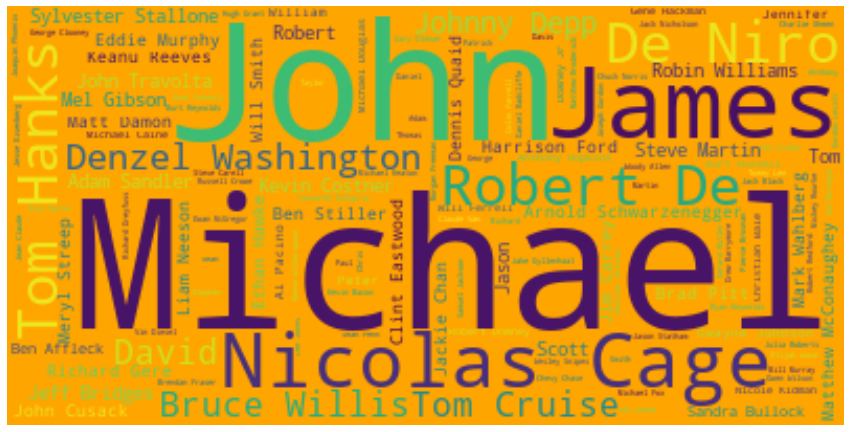

In [52]:
wordcloud = WordCloud(background_color="orange").generate(" ".join(df["star"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

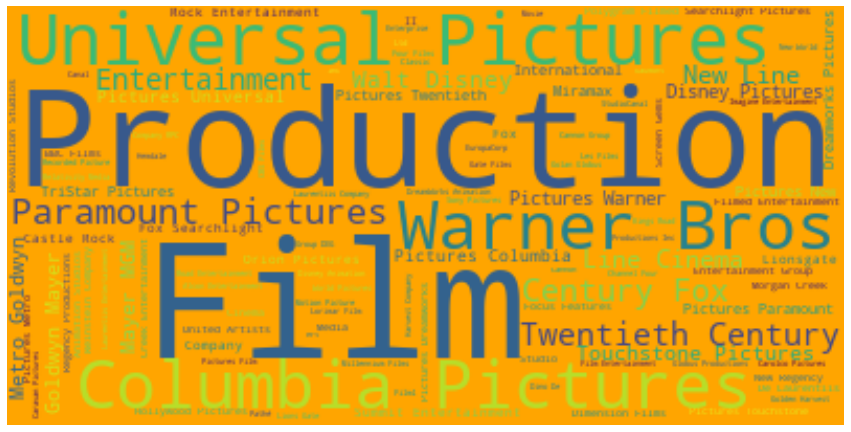

In [53]:
wordcloud = WordCloud(background_color="orange").generate(" ".join(df["company"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [54]:
"""It looks like the wordclouds are not very helpful at identifying
any frequencies about the categorical data. Let's instead run a
few lines of code to get what we are looking for."""

import collections

counter=collections.Counter(df["name"])

print(counter.most_common(10))

[('Venom', 3), ('Hercules', 3), ('Fever Pitch', 3), ("Nobody's Fool", 3), ('Anna', 3), ('Pulse', 3), ('Hamlet', 3), ('Friday the 13th', 2), ('Fame', 2), ('The Fog', 2)]


In [55]:
counter=collections.Counter(df["director"])

print(counter.most_common(10))

[('Woody Allen', 38), ('Clint Eastwood', 31), ('Steven Spielberg', 27), ('Directors', 25), ('Ron Howard', 24), ('Ridley Scott', 23), ('Steven Soderbergh', 23), ('Joel Schumacher', 22), ('Barry Levinson', 20), ('Martin Scorsese', 19)]


In [56]:
counter=collections.Counter(df["writer"])

print(counter.most_common(10))

[('Woody Allen', 37), ('Stephen King', 31), ('John Hughes', 25), ('Luc Besson', 25), ('David Mamet', 15), ('William Shakespeare', 15), ('Joel Coen', 13), ('Pedro Almodóvar', 13), ('Wes Craven', 12), ('Michael Crichton', 11)]


In [57]:
counter=collections.Counter(df["star"])

print(counter.most_common(10))

[('Nicolas Cage', 43), ('Robert De Niro', 41), ('Tom Hanks', 41), ('Denzel Washington', 37), ('Bruce Willis', 34), ('Tom Cruise', 33), ('Johnny Depp', 33), ('Sylvester Stallone', 32), ('John Travolta', 30), ('Mel Gibson', 29)]


In [58]:
counter=collections.Counter(df["company"])

print(counter.most_common(10))

[('Universal Pictures', 376), ('Warner Bros.', 332), ('Columbia Pictures', 332), ('Paramount Pictures', 319), ('Twentieth Century Fox', 240), ('New Line Cinema', 173), ('Touchstone Pictures', 132), ('Metro-Goldwyn-Mayer (MGM)', 123), ('Walt Disney Pictures', 123), ('TriStar Pictures', 94)]


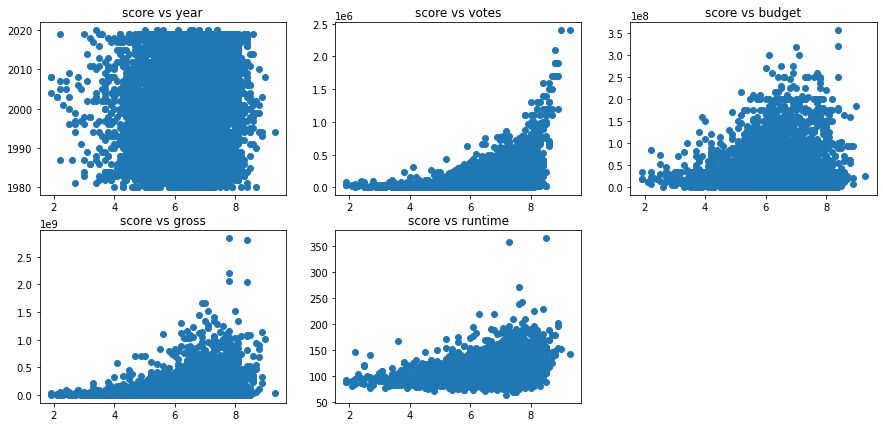

In [59]:
"""Now let's do some bivariate analysis to see if there are any relatonships between variables.

We will start with continuous-continuous variable pairs.

The continuous variables we are exploring are:
["year","score","votes","budget","gross","runtime"]

We want to examine the relationship to score first, as that's our target variable"""


plt.figure(figsize=(15,7))

plt.subplot(2,3,1)
plt.scatter(df["score"], df["year"])
plt.title("score vs year")

plt.subplot(2,3,2)
plt.scatter(df["score"], df["votes"])
plt.title("score vs votes")

plt.subplot(2,3,3)
plt.scatter(df["score"], df["budget"])
plt.title("score vs budget")

plt.subplot(2,3,4)
plt.scatter(df["score"], df["gross"])
plt.title("score vs gross")

plt.subplot(2,3,5)
plt.scatter(df["score"], df["runtime"])
plt.title("score vs runtime")

plt.show()

In [60]:
"""There seems to be a positive trend between score and votes, budget, gross, and runtime.

Let's examine the correlation coefficient to determine a if there is any statistical significance"""

df[continuous].corr()

,year,score,votes,budget,gross,runtime
year,1.000000,0.093951,0.218941,0.268662,0.258826,0.114237
score,0.093951,1.000000,0.415190,0.061506,0.188071,0.397226
votes,0.218941,0.415190,1.000000,0.420611,0.631110,0.309945
budget,0.268662,0.061506,0.420611,1.000000,0.714607,0.266956
gross,0.258826,0.188071,0.631110,0.714607,1.000000,0.245117
runtime,0.114237,0.397226,0.309945,0.266956,0.245117,1.000000


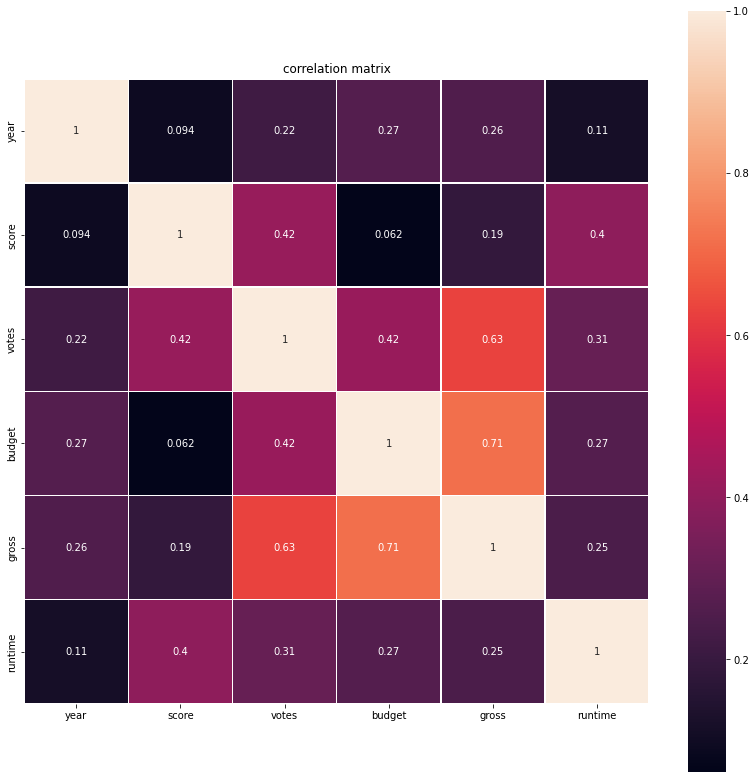

In [61]:
"""To further examine the correlation, let's make a heatmap"""

# Make the correlation matrices
corrmat = df.corr()

# Heat maps are a great way to get
# a quick visual read on a big correlation matrix.

# Draw the heat map using seaborn
plt.figure(figsize=(14,14))
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

In [62]:
"""It looks like the strongest correlation is between budget and gross. This might be because if a movie
spends more on production costs, then typicaly it will have a higher performance while it is playing
in theatres. The second strongest correlation is between gross and votes.


Now let's move on to continuous-categorical pairs

Categorical variables:
["name", "rating", "genre", "director", "writer", "star", "country", "company"]"""

df.groupby("rating").mean()

,year,score,votes,budget,gross,runtime
rating,,,,,,
Approved,1981.000000,3.400000,5300.000000,6.500000e+06,3.656528e+07,115.000000
G,1996.546053,6.582237,98190.315789,4.852470e+07,1.420433e+08,90.914474
NC-17,1997.652174,6.547826,49547.826087,2.227125e+07,1.076324e+07,108.304348
Not Rated,2007.213178,6.934496,30773.949612,3.095324e+07,1.784959e+07,118.201550
PG,1996.520492,6.223852,68163.457377,4.192791e+07,1.066129e+08,103.004098
PG-13,2003.476304,6.293825,121802.644327,4.834640e+07,1.309839e+08,109.175682
R,2000.112805,6.463221,85633.254712,2.673144e+07,4.272375e+07,107.872506
TV-14,2019.000000,6.300000,4200.000000,3.558988e+07,5.756185e+06,98.000000
TV-MA,2007.111111,7.022222,36233.333333,3.368101e+07,7.917078e+07,108.000000


In [63]:
df.groupby("genre").mean()

,year,score,votes,budget,gross,runtime
genre,,,,,,
Action,2002.201681,6.213205,143604.455582,5.502165e+07,1.458350e+08,110.435774
Adventure,1999.840095,6.290453,102848.329356,4.368217e+07,1.095587e+08,107.914081
Animation,2005.371601,6.762236,129556.897281,6.967802e+07,2.413567e+08,92.054381
Biography,2004.261072,7.042191,93139.505828,2.823302e+07,4.831195e+07,120.205128
Comedy,1998.648029,6.199083,55708.265353,2.682264e+07,4.452676e+07,101.557745
Crime,1999.789179,6.681157,92928.102612,2.592233e+07,3.976627e+07,111.925373
Drama,2000.594858,6.695344,72946.111188,2.818451e+07,3.917097e+07,113.368311
Family,1992.000000,6.540000,75340.000000,4.180393e+07,2.157876e+08,100.800000
Fantasy,1996.285714,6.050000,60857.142857,1.766166e+07,3.925157e+07,99.904762


In [64]:
df.groupby("country").mean()

,year,score,votes,budget,gross,runtime
country,,,,,,
Argentina,2002.166667,7.816667,90983.333333,1.892827e+07,2.269010e+07,117.666667
Aruba,1998.000000,4.900000,14000.000000,3.000000e+07,1.031992e+07,91.000000
Australia,2000.647059,6.670588,61947.482353,3.072135e+07,3.538122e+07,104.129412
Austria,2009.000000,7.020000,47779.600000,2.913393e+07,2.092008e+07,107.600000
Belgium,2009.125000,7.137500,65500.000000,3.130744e+07,5.060999e+06,111.625000
Brazil,2000.500000,7.700000,159333.333333,2.311160e+07,1.650788e+07,123.500000
Canada,2000.723757,6.122652,48225.182320,2.780922e+07,3.355409e+07,101.370166
Chile,2016.500000,6.600000,23500.000000,3.079494e+07,1.955851e+07,114.500000
China,2012.542857,6.734286,80580.485714,6.190597e+07,2.177334e+08,118.142857


In [65]:
df.groupby("company").mean()

,year,score,votes,budget,gross,runtime
company,,,,,,
"""DIA"" Productions GmbH & Co. KG",2003.0,6.1,46000.0,3.600000e+07,44350926.0,109.0
"""Weathering With You"" Film Partners",2019.0,7.5,28000.0,1.110000e+07,193457467.0,112.0
.406 Production,1996.0,6.8,5300.0,2.500000e+05,10580.0,96.0
1+2 Seisaku Iinkai,2000.0,8.2,22000.0,3.558988e+07,1196218.0,173.0
10 West Studios,2010.0,6.4,2600.0,3.558988e+07,814906.0,111.0
...,...,...,...,...,...,...
i am OTHER,2015.0,7.2,82000.0,7.000000e+06,17986781.0,103.0
i5 Films,2001.0,6.6,11000.0,3.000000e+06,10031529.0,101.0
iDeal Partners Film Fund,2013.0,7.5,5300.0,3.558988e+07,506303.0,108.0


In [66]:
"""Now let's do some bivariate analysis of categorical-categorical pairs"""

df[categorical].head()

,name,rating,genre,director,writer,star,country,company
0,The Shining,R,Drama,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.
1,The Blue Lagoon,R,Adventure,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm
3,Airplane!,PG,Comedy,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures
4,Caddyshack,R,Comedy,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures


In [67]:
pd.crosstab(df["rating"], df["genre"])

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western
rating,,,,,,,,,,,,,,,,,,
Approved,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,1,21,100,1,16,0,10,3,0,0,0,0,0,0,0,0,0,0
NC-17,0,0,0,1,4,3,14,0,0,1,0,0,0,0,0,0,0,0
Not Rated,45,5,8,9,42,30,104,0,2,9,0,1,1,1,1,0,0,0
PG,177,202,185,61,419,7,145,7,3,6,0,0,0,3,1,0,3,1
PG-13,618,91,23,135,722,46,388,0,9,44,0,0,4,2,3,1,3,0
R,823,98,12,219,965,440,751,0,28,243,1,0,15,2,3,0,6,2
TV-14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TV-MA,1,1,2,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0


In [68]:
pd.crosstab(df["rating"], df["country"])

country,Argentina,Aruba,Australia,Austria,Belgium,Brazil,Canada,Chile,China,Colombia,...,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Vietnam,West Germany,Yugoslavia
rating,,,,,,,,,,,,,,,,,,,,,
Approved,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
G,0,0,2,0,0,0,6,0,0,0,...,0,0,0,0,0,16,105,0,0,0
NC-17,0,0,1,0,1,0,1,0,0,0,...,0,1,0,0,0,4,7,0,0,0
Not Rated,2,0,5,1,1,0,7,0,4,0,...,1,4,1,2,0,23,39,1,1,0
PG,0,0,15,1,0,0,19,0,6,0,...,2,0,0,0,0,132,957,0,2,1
PG-13,0,0,13,1,1,0,22,1,19,0,...,0,1,0,1,2,192,1670,0,2,0
R,4,1,47,2,5,6,124,1,5,1,...,6,1,4,0,0,419,2553,0,4,2
TV-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TV-MA,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0


In [69]:
pd.crosstab(df["country"], df["genre"])

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western
country,,,,,,,,,,,,,,,,,,
Argentina,0,1,0,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0
Aruba,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia,19,10,2,7,17,5,19,0,1,5,0,0,0,0,0,0,0,0
Austria,1,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0
Belgium,1,0,0,1,1,0,4,0,0,0,0,0,1,0,0,0,0,0
Brazil,1,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0
Canada,30,10,8,8,36,13,48,1,4,23,0,0,0,0,0,0,0,0
Chile,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
China,19,3,3,2,1,0,7,0,0,0,0,0,0,0,0,0,0,0


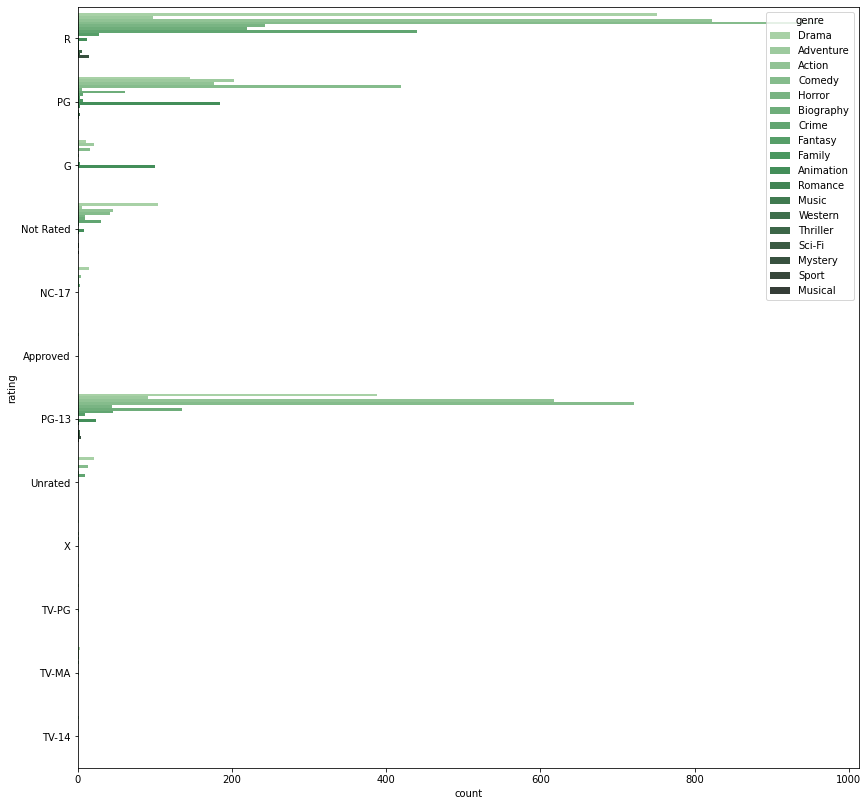

In [70]:
"""The US seems to produce the most of every kind of movie there is. Not surprising."""

"""Now let's plot our categorical pairs to visualize"""

plt.figure(figsize=(14,14))
sns.countplot(y="rating", hue="genre", data=df, palette="Greens_d")
plt.show()

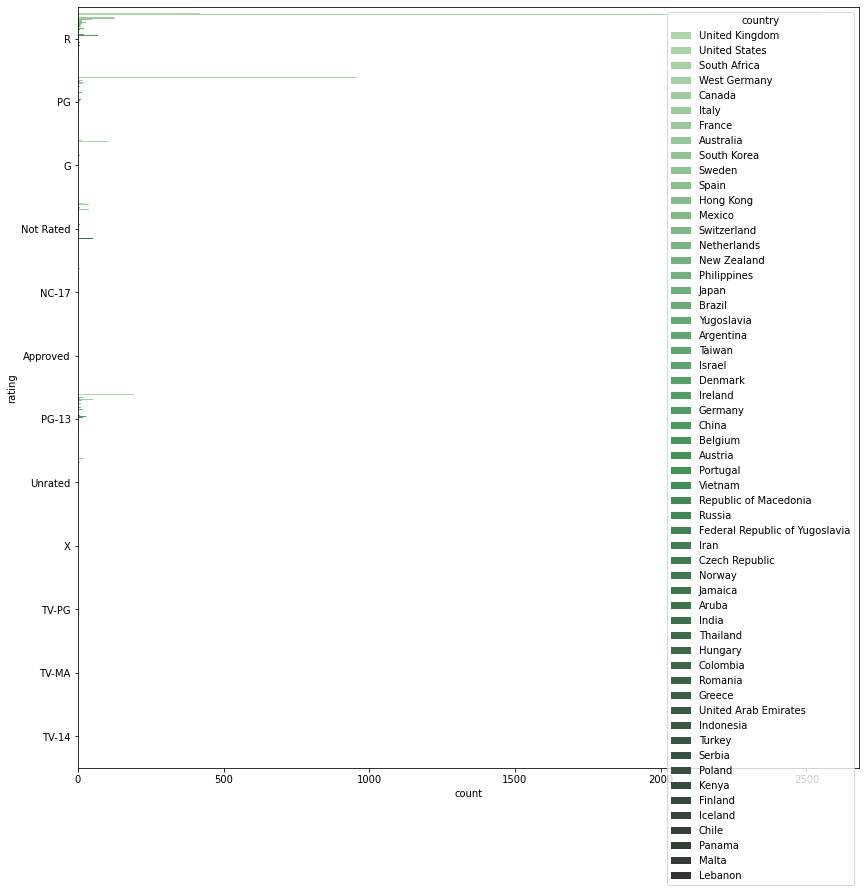

In [71]:
plt.figure(figsize=(14,14))
sns.countplot(y="rating", hue="country", data=df, palette="Greens_d")
plt.show()

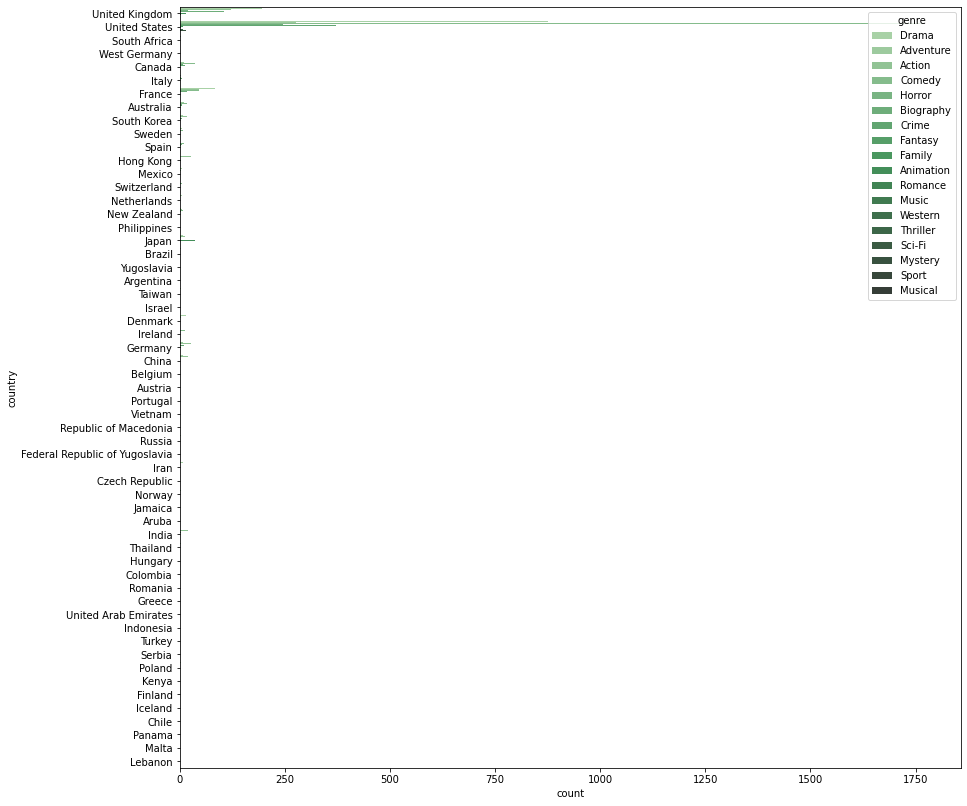

In [72]:
plt.figure(figsize=(14,14))
sns.countplot(y="country", hue="genre", data=df, palette="Greens_d")
plt.show()

In [73]:
"""Overall, we can see from the plots that the US has the highest frequency for movies and that the
rating that is the most frequent is 'R'."""

"Overall, we can see from the plots that the US has the highest frequency for movies and that the\nrating that is the most frequent is 'R'."

In [74]:
"""Now let's work with som categorical variables 'rating' and 'genre' by transforming them into 
continuous variables in order to engineer some features with the data.

Let's test the waters before adding them to our data permanently."""

# One-hot encoding the `Grade` variable: 
pd.get_dummies(df["rating"])

,Approved,G,NC-17,Not Rated,PG,PG-13,R,TV-14,TV-MA,TV-PG,Unrated,X
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7651,0,0,0,0,1,0,0,0,0,0,0,0
7652,0,0,0,1,0,0,0,0,0,0,0,0
7653,0,0,0,0,0,0,1,0,0,0,0,0
7656,0,0,0,0,0,1,0,0,0,0,0,0


In [75]:
"""Ok that seems to be manageable, let's add the two sets of dummy variables to our data permanently."""

# Append dummies to the DataFrame
df = pd.concat([df, pd.get_dummies(df["rating"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["genre"])], axis=1)
df

,name,rating,genre,year,released,score,votes,director,writer,star,...,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,...,0,0,0,0,0,0,0,0,0,0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,0,0,0,0,0,0,0,0,0,0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,...,0,0,0,0,0,0,0,0,0,0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,...,0,0,0,0,0,0,0,0,0,0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651,The Call of the Wild,PG,Adventure,2020,"February 21, 2020 (United States)",6.8,42000.0,Chris Sanders,Michael Green,Harrison Ford,...,0,0,0,0,0,0,0,0,0,0
7652,The Eight Hundred,Not Rated,Action,2020,"August 28, 2020 (United States)",6.8,3700.0,Hu Guan,Hu Guan,Zhi-zhong Huang,...,0,0,0,0,0,0,0,0,0,0
7653,The Quarry,R,Crime,2020,"April 17, 2020 (Mexico)",5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,...,0,0,0,0,0,0,0,0,0,0
7656,Tulsa,PG-13,Comedy,2020,"June 3, 2020 (United States)",5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,...,0,0,0,0,0,0,0,0,0,0


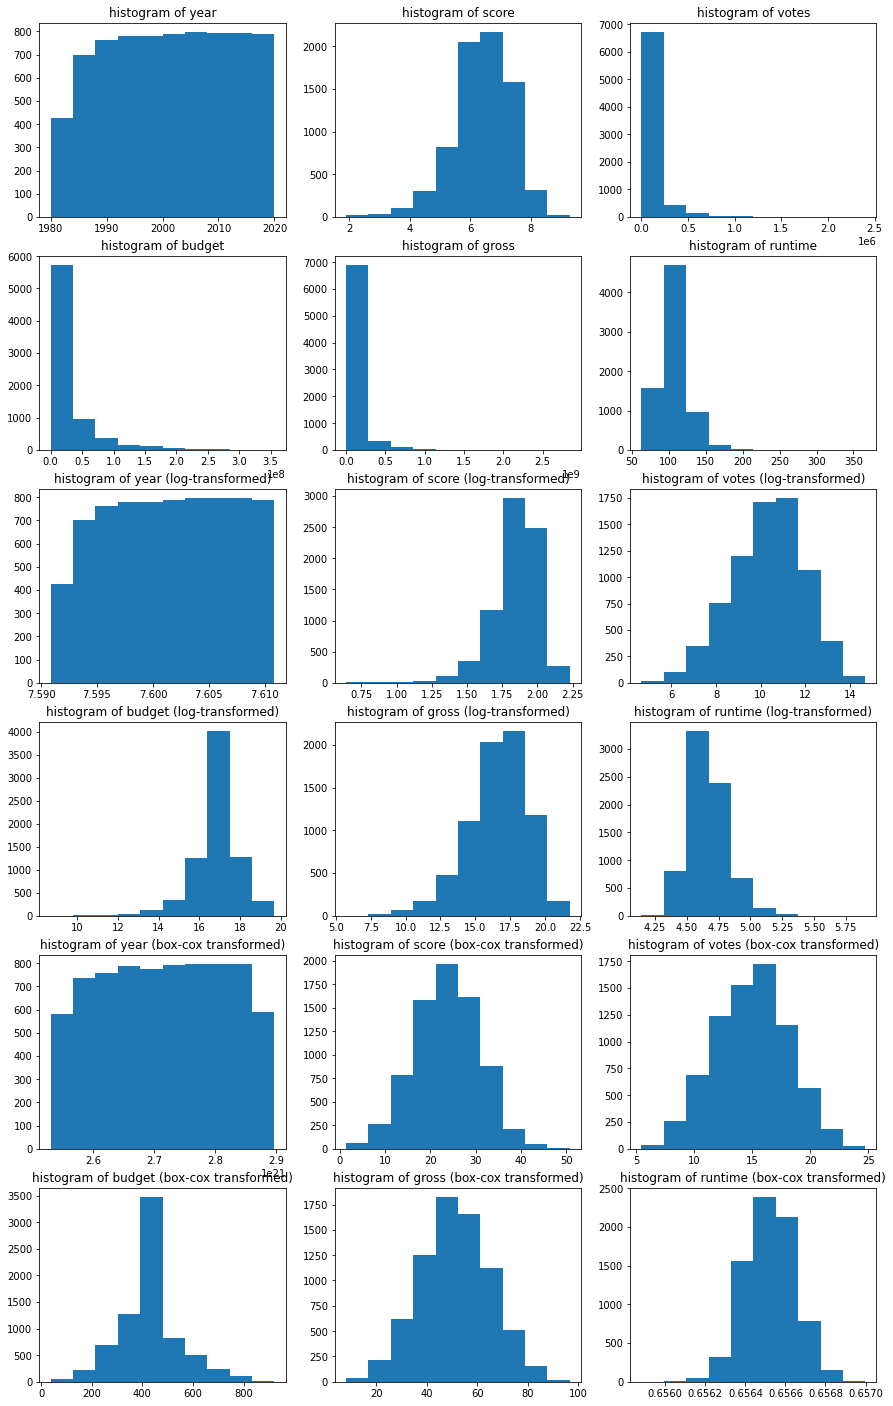

In [76]:
plt.figure(figsize=(15, 25))

# Histograms of the original continuous variables 
#["year","score","votes","budget","gross","runtime"]

plt.subplot(6, 3, 1)
plt.hist(df["year"])
plt.title("histogram of year")

plt.subplot(6, 3, 2)
plt.hist(df["score"])
plt.title("histogram of score")

plt.subplot(6, 3, 3)
plt.hist(df["votes"])
plt.title("histogram of votes")

plt.subplot(6, 3, 4)
plt.hist(df["budget"])
plt.title("histogram of budget")

plt.subplot(6, 3, 5)
plt.hist(df["gross"])
plt.title("histogram of gross")

plt.subplot(6, 3, 6)
plt.hist(df["runtime"])
plt.title("histogram of runtime")

#Histograms of log-transformed variables
plt.subplot(6, 3, 7)
plt.hist(np.log(df["year"]))
plt.title("histogram of year (log-transformed)")

plt.subplot(6, 3, 8)
plt.hist(np.log(df["score"]))
plt.title("histogram of score (log-transformed)")

plt.subplot(6, 3, 9)
plt.hist(np.log(df["votes"]))
plt.title("histogram of votes (log-transformed)")

plt.subplot(6, 3, 10)
plt.hist(np.log(df["budget"]))
plt.title("histogram of budget (log-transformed)")

plt.subplot(6, 3, 11)
plt.hist(np.log(df["gross"]))
plt.title("histogram of gross (log-transformed)")

plt.subplot(6, 3, 12)
plt.hist(np.log(df["runtime"]))
plt.title("histogram of runtime (log-transformed)")


# Histograms of the Box-Cox-transformed data
from scipy.stats import boxcox

year_boxcox,_ = boxcox(df["year"])
score_boxcox,_ = boxcox(df["score"])
votes_boxcox,_ = boxcox(df["votes"])
budget_boxcox,_ = boxcox(df["budget"])
gross_boxcox,_ = boxcox(df["gross"])
runtime_boxcox,_ = boxcox(df["runtime"])

plt.subplot(6, 3, 13)
plt.hist(year_boxcox)
plt.title("histogram of year (box-cox transformed)")

plt.subplot(6, 3, 14)
plt.hist(score_boxcox)
plt.title("histogram of score (box-cox transformed)")

plt.subplot(6, 3, 15)
plt.hist(votes_boxcox)
plt.title("histogram of votes (box-cox transformed)")

plt.subplot(6, 3, 16)
plt.hist(budget_boxcox)
plt.title("histogram of budget (box-cox transformed)")

plt.subplot(6, 3, 17)
plt.hist(gross_boxcox)
plt.title("histogram of gross (box-cox transformed)")

plt.subplot(6, 3, 18)
plt.hist(runtime_boxcox)
plt.title("histogram of runtime (box-cox transformed)")

#new continuous variables list: 
#["year","score","votes","budget","gross","runtime", "year_boxcox","score_boxcox",
#"votes_boxcox","budget_boxcox","gross_boxcox","runtime_boxcox"]


plt.show()

In [77]:
"""It looks like out boxcox-transformed variables resemble the closest to a normal distribution.
Let's confirm this with some statistical tests to be certain."""

"It looks like out boxcox-transformed variables resemble the closest to a normal distribution.\nLet's confirm this with some statistical tests to be certain."

In [78]:
"""That seemed to work nicely.

Next, we will use normality tests and jarque bera tests to test for normality of distribution
of our raw and boxcox-transformed variables. Some machine learning models prefer more 
normally distributed variables. So we will aim to give the models what they need to work properly."""


from scipy.stats import jarque_bera
from scipy.stats import normaltest


#Normaliy test of the original variables
jb_stats = jarque_bera(df["year"])
norm_stats = normaltest(df["year"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["score"])
norm_stats = normaltest(df["score"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["votes"])
norm_stats = normaltest(df["votes"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["budget"])
norm_stats = normaltest(df["budget"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["gross"])
norm_stats = normaltest(df["gross"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["runtime"])
norm_stats = normaltest(df["runtime"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 411.9941581590064 and p value is 0.0
Normality test statistics is 4253.20034090541 and p value is 0.0
Jarque-Bera test statistics is 744.7606947077539 and p value is 0.0
Normality test statistics is 532.4543048138369 and p value is 2.3934082123285598e-116
Jarque-Bera test statistics is 431031.515067062 and p value is 0.0
Normality test statistics is 7336.422108998435 and p value is 0.0
Jarque-Bera test statistics is 49424.638090230685 and p value is 0.0
Normality test statistics is 4589.228786084169 and p value is 0.0
Jarque-Bera test statistics is 667621.6772741001 and p value is 0.0
Normality test statistics is 7866.428820123341 and p value is 0.0
Jarque-Bera test statistics is 64059.80762675316 and p value is 0.0
Normality test statistics is 3880.9144541653295 and p value is 0.0


In [79]:
"""The p-values for our tests are all under 0.05 meaning that we can assume that they 
do not have a normal distribution.

Normality test of the boxcox-transformed variables was unsuccessful.

Let's see if there are any combinations of variables that are highly correlated that we can make into
new variables. We will go back to our correlation matrix from above.

'budget' and 'gross' are highly correlated, so we will combine them into a single variable to observe 
the interaction and add it
to the dataset."""



"The p-values for our tests are all under 0.05 meaning that we can assume that they \ndo not have a normal distribution.\n\nNormality test of the boxcox-transformed variables was unsuccessful.\n\nLet's see if there are any combinations of variables that are highly correlated that we can make into\nnew variables. We will go back to our correlation matrix from above.\n\n'budget' and 'gross' are highly correlated, so we will combine them into a single variable to observe \nthe interaction and add it\nto the dataset."

In [80]:
"""Next, we will normalize the data to be able to apply techniques such as PCA and some machine learning
models."""

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(df.select_dtypes(include='float64'))

# The NumPy covariance function assumes that variables are represented by rows,
# not columns. So transpose `X`.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00013493 0.41524579 0.061514   0.18809652 0.39727935]
 [0.41524579 1.00013493 0.42066807 0.63119533 0.30998655]
 [0.061514   0.42066807 1.00013493 0.71470307 0.26699212]
 [0.18809652 0.63119533 0.71470307 1.00013493 0.24514986]
 [0.39727935 0.30998655 0.26699212 0.24514986 1.00013493]]


In [81]:
# Calculating eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The proportion of total variance in the dataset explained by each',
    'component calculated by hand\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.31992594 -0.51363115 -0.47023095 -0.53337286 -0.35808753]
Eigenvalue 1: 2.515471024513461
----------------------------------------
Eigenvector 2: 
[-0.67339437 -0.04409515  0.45307655  0.35631525 -0.46082179]
Eigenvalue 2: 1.1582786574296442
----------------------------------------
Eigenvector 3: 
[-0.35419908 -0.45754561  0.28231482 -0.10470771  0.75797735]
Eigenvalue 3: 0.6929460543293813
----------------------------------------
Eigenvector 4: 
[ 0.56436101 -0.6209779   0.46529212  0.0368103  -0.27934093]
Eigenvalue 4: 0.409575056799363
----------------------------------------
Eigenvector 5: 
[ 0.0150694  -0.37319851 -0.52669353  0.75910087  0.08279843]
Eigenvalue 5: 0.22440387971185188
----------------------------------------
The proportion of total variance in the dataset explained by each component calculated by hand
 [0.50302633 0.23162448 0.13857051 0.08190396 0.04487472]


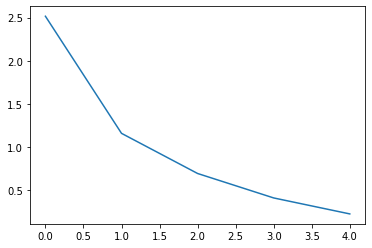

[2.51547102 1.15827866 0.69294605 0.40957506 0.22440388]


In [82]:
"""How many components to keep?

Strategy: Keep components with eigenvalues greater than 1, because they add value 
(more than a single variable would).

If we use that strategy, we will use eigenvalues: 1 and 2

Or...

We can use a scree plot to visually inspect the plot and keep all the components 
whose eigenvalue falls above the point where the slope of the line changes the most 
drastically. This point is also called the elbow."""

# Print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [83]:
"""There doesn't seem to be an observable elbow in the scree plot and it says to only keep 
the first 5 eigenvalues.

Now let's confirm with sklearn function."""

sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform `X` into `Y`.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.50302633 0.23162448 0.13857051 0.08190396 0.04487472]


In [84]:
"""Let's try some other methods of dimensionality reduction. We will come back to PCA if we need to.

Let's start with UMAP."""

"Let's try some other methods of dimensionality reduction. We will come back to PCA if we need to.\n\nLet's start with UMAP."

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7412 entries, 0 to 7659
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       7412 non-null   object 
 1   rating     7412 non-null   object 
 2   genre      7412 non-null   object 
 3   year       7412 non-null   int64  
 4   released   7412 non-null   object 
 5   score      7412 non-null   float64
 6   votes      7412 non-null   float64
 7   director   7412 non-null   object 
 8   writer     7412 non-null   object 
 9   star       7412 non-null   object 
 10  country    7412 non-null   object 
 11  budget     7412 non-null   float64
 12  gross      7412 non-null   float64
 13  company    7412 non-null   object 
 14  runtime    7412 non-null   float64
 15  Approved   7412 non-null   uint8  
 16  G          7412 non-null   uint8  
 17  NC-17      7412 non-null   uint8  
 18  Not Rated  7412 non-null   uint8  
 19  PG         7412 non-null   uint8  
 20  PG-13   

In [86]:
"""UMAP requires all data to be numerical, so we will only work with the variables that are numerical
and the ones that we have transformed into numerical variables via the 'getdummies' method.

That list is:"""

df_num = df[['year', 'score', 'votes', 'budget', 'gross', 'runtime']]


In [87]:
df_num

,year,score,votes,budget,gross,runtime
0,1980,8.4,927000.0,1.900000e+07,46998772.0,146.0
1,1980,5.8,65000.0,4.500000e+06,58853106.0,104.0
2,1980,8.7,1200000.0,1.800000e+07,538375067.0,124.0
3,1980,7.7,221000.0,3.500000e+06,83453539.0,88.0
4,1980,7.3,108000.0,6.000000e+06,39846344.0,98.0
...,...,...,...,...,...,...
7651,2020,6.8,42000.0,1.350000e+08,111105497.0,100.0
7652,2020,6.8,3700.0,8.000000e+07,461421559.0,149.0
7653,2020,5.4,2400.0,3.558988e+07,3661.0,98.0
7656,2020,5.0,294.0,3.558988e+07,413378.0,120.0


In [88]:
df_num.dtypes

year         int64
score      float64
votes      float64
budget     float64
gross      float64
runtime    float64
dtype: object

In [89]:
X = df_num
y = df_num.score

print(X.shape, y.shape)

(7412, 6) (7412,)


In [ ]:
import umap.umap_ as umap

time_start = time.time()

umap_results = umap.UMAP(n_neighbors=10,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
umap_results.shape

In [ ]:
y

In [ ]:
print(umap_results)

In [ ]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y"]
#for i in range(umap_results.shape[0]):
plt.scatter(umap_results[:, 0], umap_results[:, 1])
             #color=colours[i],
             #fontdict={'weight': 'bold', 'size': 100}

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
"""Now let's try some PCA"""

#Standardizing the faetures
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# You just want the first 5 principal components
pca = PCA(n_components=5)

# Get the components by 
# calling `fit_transform()` method with the data
pca_components = pca.fit_transform(X_std)

In [ ]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse", "w", "gold", "wheat", "silver", "maroon", "coral", "chocolate", "indigo"]
#for i in range(pca_components.shape[0]):
plt.scatter(pca_components[:, 0], pca_components[:, 1])
             #color=colours[i],
             #fontdict={'weight': 'bold', 'size': 50}

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
"""It looks like UMAP is the better algorithm for dimensionality reduction.
It seems to separate the data in a more easy to understand visualization."""

In [ ]:
"""Now on to clustering. We will staert with k-means"""

#Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=5, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

In [ ]:
# Plot the solution using umap_results.

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(y_pred[i]),
             color=colours[y_pred[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
"""Now let's evaluate the clusters with RI, ARI and silhouette scores."""

def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [ ]:
rand_index_score(y, y_pred)

In [ ]:
metrics.adjusted_rand_score(y, y_pred)

In [ ]:
"""ARI is evaluated on a score between 0 and 1, where 0 indicates random labeling and 
1 indicates perfect replication of the ground truth.

Our ARI is very low, which makes sense considering we do not have a ground truth to label our data."""

In [ ]:
labels = KMeans(n_clusters=5, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

In [ ]:
"""For the silhouette score, values range from -1 for very bad clusters to +1 for very dense clusters.
Our silhouette score of 0.21 is good, but et's try to tune the model to see if we
can improve it's performance."""

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

In [ ]:
labels = KMeans(n_clusters=7, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

In [ ]:
labels = KMeans(n_clusters=8, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

In [ ]:
"""It appears that n=7 is the best result of tuning we can get.

Now on to DBSCAN approach to clustering."""

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

In [ ]:
plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters[i]),
             color=colours[clusters[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
"""DBSCAN seems to have produced an error and we can't see if it worked more effectively than K-means. Let's
evaluate with RI, ARI and silhouette scores."""

rand_index_score(y, clusters)

In [ ]:
"""Data set is not pre-labeled, so there is no 'ground truth' to calculate and evaluate against."""

In [ ]:
metrics.adjusted_rand_score(y, clusters)

In [ ]:
print(metrics.silhouette_score(X_std, clusters, metric='euclidean'))

In [ ]:
"""After comparing the clustering models, it seems that DBSCAN is the superior model. 
Although the RI and ARI did not compute properly, we were able to use the silhouette score to 
compare evaluations of the two models. The silhouette score worked best to evaluate 
because the dataset is not pre-labeled, meaning that it has no pre-existing ground truth to make 
RI and ARI work. The K-means clustering model had a silhouette score of 0.23 at it's best 
while the DBSCAN had a score of 0.40."""